<a href="https://colab.research.google.com/github/jakartaresearch/quora-question-pairs/blob/master/R5_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.2 GB  | Proc size: 159.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 1. Setup

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive/"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

import pickle
import os
import glob
import pandas as pd
import nltk
import numpy as np
from tqdm import tqdm_notebook, tqdm
tqdm_notebook().pandas()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## 1.1 Using Colab GPU for training

In [0]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2 Install Hugging Face library

In [0]:
!pip install transformers --q

# 2. Load Quora Dataset

In [0]:
data_path = 'drive/My Drive/Colab Notebooks/quora-question-pairs/data/'
kfold_folder = glob.glob(data_path+'cross_validation_data/*')
train_id_file = '/train_id.csv'
val_id_file = '/val_id.csv'

In [0]:
def read_csv(path):
    data = pd.read_csv(path)
    return data

def remove_row_nan(df):
    df = df.dropna(axis = 0)
    return df

In [0]:
data = pd.read_csv(data_path+'quora_duplicate_questions.tsv', sep='\t')
data = remove_row_nan(data)

In [0]:
train_kf = []
val_kf = [] 

for kf, path in enumerate(kfold_folder,1):
    print('Load KFold data from =', path)
    print('KFold -',kf)
    train_id = read_csv(path + train_id_file)
    val_id = read_csv(path + val_id_file)

    # Get specific data by id
    train = data[data.id.isin(train_id.id.values)]
    val = data[data.id.isin(val_id.id.values)]

    # random sample data
    train = train.sample(frac=1, random_state=42)
    val = val.sample(frac=1, random_state=42)
    train_kf.append(train)
    val_kf.append(val)

Load KFold data from = drive/My Drive/Colab Notebooks/quora-question-pairs/data/cross_validation_data/5
KFold - 1
Load KFold data from = drive/My Drive/Colab Notebooks/quora-question-pairs/data/cross_validation_data/3
KFold - 2
Load KFold data from = drive/My Drive/Colab Notebooks/quora-question-pairs/data/cross_validation_data/2
KFold - 3
Load KFold data from = drive/My Drive/Colab Notebooks/quora-question-pairs/data/cross_validation_data/1
KFold - 4
Load KFold data from = drive/My Drive/Colab Notebooks/quora-question-pairs/data/cross_validation_data/4
KFold - 5


# 3. Tokenization & Input Formatting

In [0]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Loading BERT tokenizer...


In [0]:
import statistics
sent_length = []

# For every sentence...
for sent in tqdm(data.question1):
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

for sent in tqdm(data.question2):
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('')
print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))


100%|██████████| 404287/404287 [01:19<00:00, 5063.46it/s]



Average length =  16.124631759121613
Median length =  14.0


Max length di set menjadi 64

# Data Preprocessing

In [0]:
ListTrainDataset = []
ListValDataset = []
train_data = True

# for train and validation data
for purpose_data in [train_kf, val_kf]:
    print('Processing Train Data') if train_data == True else print('Processing Validation Data')
    # for every KFold data
    for kf in tqdm(range(5)):
        print('KFold-', kf+1)
        # Tokenize all of the sentences and map the tokens to their word IDs.
        input_ids = []
        token_type_ids = []
        attention_masks = []

        for sent in purpose_data[kf].itertuples():
            encoded_dict = tokenizer.encode_plus(
                                text = sent.question1,
                                text_pair = sent.question2,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                            )
            
            input_ids.append(encoded_dict['input_ids'])
            token_type_ids.append(encoded_dict['token_type_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        token_type_ids = torch.cat(token_type_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        if train_data == True :
            labels = torch.tensor(train_kf[kf].is_duplicate.values)
            ListTrainDataset.append({'input_ids':input_ids, 'token_type_ids':token_type_ids,
                                'attention_masks':attention_masks, 'labels':labels})
            print('Train Dataset done for KFold-', kf+1)
        else :
            labels = torch.tensor(val_kf[kf].is_duplicate.values)
            ListValDataset.append({'input_ids':input_ids, 'token_type_ids':token_type_ids,
                                'attention_masks':attention_masks, 'labels':labels})
            print('Validation Dataset done for KFold-', kf+1)
            
    train_data = False

  0%|          | 0/5 [00:00<?, ?it/s]

Processing Train Data
KFold- 1


 20%|██        | 1/5 [02:17<09:10, 137.72s/it]

Train Dataset done for KFold- 1
KFold- 2


 40%|████      | 2/5 [04:36<06:54, 138.02s/it]

Train Dataset done for KFold- 2
KFold- 3


 60%|██████    | 3/5 [06:53<04:35, 137.58s/it]

Train Dataset done for KFold- 3
KFold- 4


 80%|████████  | 4/5 [09:10<02:17, 137.59s/it]

Train Dataset done for KFold- 4
KFold- 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train Dataset done for KFold- 5
Processing Validation Data
KFold- 1


 20%|██        | 1/5 [00:34<02:16, 34.08s/it]

Validation Dataset done for KFold- 1
KFold- 2


 40%|████      | 2/5 [01:08<01:42, 34.07s/it]

Validation Dataset done for KFold- 2
KFold- 3


 60%|██████    | 3/5 [01:42<01:08, 34.10s/it]

Validation Dataset done for KFold- 3
KFold- 4


 80%|████████  | 4/5 [02:16<00:34, 34.15s/it]

Validation Dataset done for KFold- 4
KFold- 5


100%|██████████| 5/5 [02:50<00:00, 34.11s/it]

Validation Dataset done for KFold- 5


In [0]:
## Save Dataset to pickle
with open(data_path+'ListTrainDataset.pkl', 'wb') as f:
    pickle.dump(ListTrainDataset, f)
with open(data_path+'ListValDataset.pkl', 'wb') as f:
    pickle.dump(ListValDataset, f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
## Load Dataset from pickle
ListTrainDataset = pickle.load(open(data_path+'ListTrainDataset.pkl', 'rb'))
ListValDataset = pickle.load(open(data_path+'ListValDataset.pkl', 'rb'))

# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 2, 
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 4.2. Optimizer & Learning Rate Scheduler

Untuk fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 3

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

## 4.3. Training Loop

**Training:**
- Unpack our data inputs and labels
- Load data to GPU
- Clear out the gradients calculated in the previous pass. 
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data to GPU
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Define a helper function for calculating accuracy.

In [0]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Ready to kick off the training!

In [0]:
import random
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

epochs = 3
batch_size = 32

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each KFold
for kf in range(1):
    print('============= Data KFold-{:} ============='.format(kf+1))
    # unpack value, and create TensorDataset
    t_input_ids, t_token_type_ids, t_attention_mask, t_labels = ListTrainDataset[kf].values()
    train_dataset = TensorDataset(t_input_ids, t_token_type_ids, t_attention_mask, t_labels)
    # DataLoader for train dataset
    train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
    
    # unpack value, and create TensorDataset
    v_input_ids, v_token_type_ids, v_attention_mask, v_labels = ListValDataset[kf].values()
    val_dataset = TensorDataset(v_input_ids, v_token_type_ids, v_attention_mask, v_labels)
    # DataLoader for val dataset
    validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
    
    # Create the learning rate scheduler.
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Tracking metrics
        total_train_loss = 0
        total_train_accuracy = 0
        total_train_f1 = 0
        total_train_prec = 0
        total_train_rec = 0

        # Put the model into training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 1000 batches.
            if step % 1000 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # `batch` contains four pytorch tensors:
            #   [0]: input ids
            #   [1]: token_ids 
            #   [2]: attention masks
            #   [3]: labels 
            b_input_ids = batch[0].to(device)
            b_token_ids = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)

            # Always clear any previously calculated gradients before performing a backward pass
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # token_type_ids is same as the "segment ids", which differentiates 
            # sentence 1 and 2 in sentence-pair tasks
            loss, logits = model(b_input_ids, 
                                token_type_ids=b_token_ids,
                                attention_mask=b_input_mask, 
                                labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. 
            total_train_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch and accumulate it over all batches.
            total_train_accuracy += flat_accuracy(logits, label_ids)
            total_train_f1 += f1_score(label_ids, np.argmax(logits, axis=1))
            total_train_prec += precision_score(label_ids, np.argmax(logits, axis=1))
            total_train_rec += recall_score(label_ids, np.argmax(logits, axis=1))

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss and accuracy over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        avg_train_f1 = total_train_f1 / len(train_dataloader)
        avg_train_prec = total_train_prec / len(train_dataloader)
        avg_train_rec = total_train_rec / len(train_dataloader)      
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average loss: {0:.2f}".format(avg_train_loss))
        print("  Average accuracy: {0:.2f}".format(avg_train_accuracy))
        print("  Average f1: {0:.2f}".format(avg_train_f1))
        print("  Average prec: {0:.2f}".format(avg_train_prec))
        print("  Average rec: {0:.2f}".format(avg_train_rec))  
        print("  Training epoch took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode (batchnorm, dropout disable)
        model.eval()

        # Tracking metrics 
        total_eval_loss = 0
        total_eval_accuracy = 0
        total_eval_f1 = 0
        total_eval_prec = 0
        total_eval_rec = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_token_ids = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                (loss, logits) = model(b_input_ids, 
                                      token_type_ids=b_token_ids, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_f1 += f1_score(label_ids, np.argmax(logits, axis=1))
            total_eval_prec += precision_score(label_ids, np.argmax(logits, axis=1))
            total_eval_rec += recall_score(label_ids, np.argmax(logits, axis=1))
            

        # Report the final metrics
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_f1 = total_eval_f1 / len(validation_dataloader)
        avg_val_prec = total_eval_prec / len(validation_dataloader)
        avg_val_rec = total_eval_rec / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Average loss: {0:.2f}".format(avg_val_loss))
        print("  Average accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  Average f1: {0:.2f}".format(avg_val_f1))
        print("  Average prec: {0:.2f}".format(avg_val_prec))
        print("  Average rec: {0:.2f}".format(avg_val_rec))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {    
                'KFold': kf + 1, 
                'Epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Validation Loss': avg_val_loss,
                'Training Accuracy': avg_train_accuracy,
                'Validation Accuracy': avg_val_accuracy,
                'Training F1': avg_train_f1,
                'Validation F1': avg_val_f1,
                'Training Precision': avg_train_prec,
                'Validation Precision': avg_val_prec,
                'Training Recall': avg_train_rec,
                'Validation Recall': avg_val_rec,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

============= Data KFold-1 =============

======== Epoch 1 / 3 ========
Training...
  Batch 1,000  of  10,108.    Elapsed: 0:03:29.
  Batch 2,000  of  10,108.    Elapsed: 0:06:58.
  Batch 3,000  of  10,108.    Elapsed: 0:10:27.
  Batch 4,000  of  10,108.    Elapsed: 0:13:55.
  Batch 5,000  of  10,108.    Elapsed: 0:17:23.
  Batch 6,000  of  10,108.    Elapsed: 0:20:51.
  Batch 7,000  of  10,108.    Elapsed: 0:24:19.
  Batch 8,000  of  10,108.    Elapsed: 0:27:47.
  Batch 9,000  of  10,108.    Elapsed: 0:31:16.
  Batch 10,000  of  10,108.    Elapsed: 0:34:45.

  Average loss: 0.15
  Average accuracy: 0.94
  Average f1: 0.92
  Average prec: 0.91
  Average rec: 0.94
  Training epoch took: 0:35:08

Running Validation...
  Average loss: 0.29
  Average accuracy: 0.90
  Average f1: 0.86
  Average prec: 0.86
  Average rec: 0.88
  Validation took: 0:02:32

======== Epoch 2 / 3 ========
Training...
  Batch 1,000  of  10,108.    Elapsed: 0:03:28.
  Batch 2,000  of  10,108.    Elapsed: 0:06:56.
  

Let's view the summary of the training process.

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,KFold,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training F1,Validation F1,Training Precision,Validation Precision,Training Recall,Validation Recall,Training Time,Validation Time
Epoch,,,,,,,,,,,,,
1,1,0.15,0.29,0.94,0.90,0.92,0.86,0.91,0.86,0.94,0.88,0:35:08,0:02:32
2,1,0.10,0.35,0.97,0.91,0.95,0.87,0.95,0.86,0.97,0.89,0:35:04,0:02:32
3,1,0.06,0.45,0.98,0.91,0.97,0.87,0.97,0.87,0.98,0.88,0:34:54,0:02:32


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


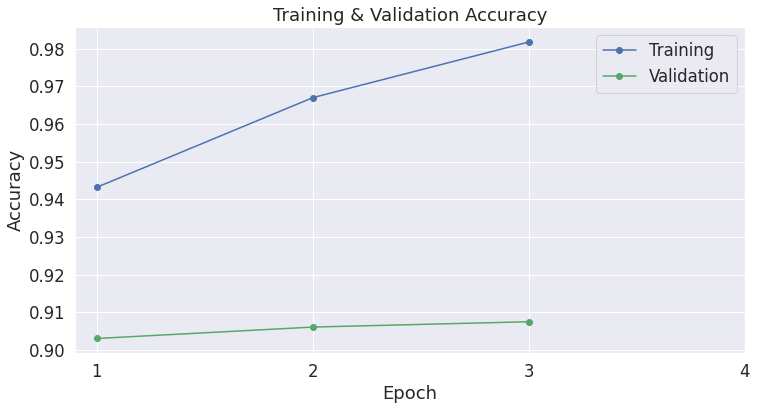

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Accuracy'], 'b-o', label="Training")
plt.plot(df_stats['Validation Accuracy'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving Model

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'drive/My Drive/Colab Notebooks/quora-question-pairs/model/'

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to drive/My Drive/Colab Notebooks/quora-question-pairs/model/


('drive/My Drive/Colab Notebooks/quora-question-pairs/model/vocab.txt',
 'drive/My Drive/Colab Notebooks/quora-question-pairs/model/special_tokens_map.json',
 'drive/My Drive/Colab Notebooks/quora-question-pairs/model/added_tokens.json')